In [ ]:


from duckdb import df
import pandas as pd
import os
from pathlib import Path

input_iso = "ITA"
tsopt = 'ts_336'

models_dir = Path("C:/Veda/Veda/Veda_models/vervestacks_models")
dest_folder = models_dir / f"VerveStacks_{input_iso}"


source_file = "assumptions/tsparameters_scen.xlsx"
excel_path = dest_folder / "SuppXLS" / f"scen_tsparameters_{tsopt}.xlsx"

# Copy the source file to the excel path
import shutil
shutil.copy(source_file, excel_path)


df_sarah_iso = pd.read_csv("data/sarah_era5_iso.csv")
df_sarah_iso = df_sarah_iso[df_sarah_iso["iso"] == input_iso]


distinct_times = df_sarah_iso[['month', 'day', 'hour']].drop_duplicates().sort_values(['month', 'day', 'hour'])

aopt_timeslice_df = pd.read_excel("assumptions/VS_Mappings.xlsx", sheet_name="aopt_timeslice")



# Join distinct_times with aopt_timeslice_df on month = source_value when description == 'month'

# First, filter aopt_timeslice_df for rows where description == 'month'
aopt_month = aopt_timeslice_df[aopt_timeslice_df['description'] == 'month']
aopt_hour = aopt_timeslice_df[aopt_timeslice_df['description'] == 'hour']

# # Now, perform the join: distinct_times.month == aopt_month.source_value
joined_df = pd.merge(
    distinct_times.assign(month=distinct_times['month'].astype(int),hour=distinct_times['hour'].astype(int)),
    aopt_month.assign(sourcevalue=aopt_month['sourcevalue'].astype(int))[['sourcevalue',tsopt]],
    left_on='month',
    right_on='sourcevalue',
    how='left'
)
joined_df = joined_df.rename(columns={tsopt: "season"})


joined_df = pd.merge(
    joined_df,
    aopt_hour.assign(sourcevalue=aopt_hour['sourcevalue'].astype(int))[['sourcevalue',tsopt]],
    left_on=['hour'],
    right_on=['sourcevalue'],
    how='left'
)
joined_df = joined_df.rename(columns={tsopt: "daynite"})
joined_df['weekly'] = 'a'


# Start fresh - Map sourcevalue 'b' from adv df to weekly column based on mm-dd range
aopt_adv = aopt_timeslice_df[aopt_timeslice_df['description'] == 'adv']

# display(aopt_adv)


# Step 3: For each row in adv_df, parse the mm-dd range and update weekly column
for idx, row in aopt_adv.iterrows():
    sourcevalue = row['sourcevalue'] 
    option1_value = row[tsopt]
    
    
    if pd.isna(option1_value):
        continue
        
    # Parse mm-dd range from option1 (e.g., "01-21" or "01-21 to 02-15")
    try:
        if 'to' in str(option1_value):
            # Range format: "01-21 to 02-15"
            start_str, end_str = str(option1_value).split(' to ')
            start_month, start_day = map(int, start_str.split('-'))
            end_month, end_day = map(int, end_str.split('-'))
        else:
            # Single date format: "01-21"
            start_month, start_day = map(int, str(option1_value).split('-'))
            end_month, end_day = start_month, start_day
            
        
        # Step 4: Update weekly column for matching (month, day) combinations
        mask = (
            ((joined_df['month'] == start_month) & (joined_df['day'] >= start_day)) |
            ((joined_df['month'] > start_month) & (joined_df['month'] < end_month)) |
            ((joined_df['month'] == end_month) & (joined_df['day'] <= end_day))
        )
        
        # Handle single month case
        if start_month == end_month:
            mask = (joined_df['month'] == start_month) & (joined_df['day'] >= start_day) & (joined_df['day'] <= end_day)
        
        rows_updated = mask.sum()
        joined_df.loc[mask, 'weekly'] = sourcevalue
        
    except Exception as e:
        print(f"  Error parsing '{option1_value}': {e}")


# Update daynite with month-hour when weekly != 'a'


# Create month-hour format for rows where weekly != 'a'
# Update daynite with mmdd+'h'+hh format for rows where weekly != 'a'
mask = joined_df['weekly'] != 'a'
joined_df.loc[mask, 'daynite'] = (
    joined_df.loc[mask, 'month'].astype(int).astype(str).str.zfill(2) +
    joined_df.loc[mask, 'day'].astype(int).astype(str).str.zfill(2) +
    'h' +
    joined_df.loc[mask, 'hour'].astype(int).astype(str).str.zfill(2)
)


########################################################
final_for_aggregations_df = joined_df
# display(final_for_aggregations_df)

del joined_df
########################################################



distinct_df = final_for_aggregations_df[['season', 'weekly', 'daynite']].drop_duplicates().reset_index(drop=True)
# Get unique values for each column as separate DataFrames
season_unique = pd.DataFrame({'season': distinct_df['season'].unique()})
weekly_unique = pd.DataFrame({'weekly': distinct_df['weekly'].unique()})
daynite_unique = pd.DataFrame({'daynite': distinct_df['daynite'].unique()})

# Sort each DataFrame by its column
season_unique_sorted = season_unique.sort_values(by='season').reset_index(drop=True)
weekly_unique_sorted = weekly_unique.sort_values(by='weekly').reset_index(drop=True)
daynite_unique_sorted = daynite_unique.sort_values(by='daynite').reset_index(drop=True)


# Get unique seasons for each weekly value
season_by_weekly = distinct_df.groupby('weekly')['season'].unique().apply(list).reset_index()

season_by_weekly['wparent'] = season_by_weekly['season'].apply(lambda x: ','.join([str(s) for s in x if pd.notnull(s)]))
season_by_weekly = season_by_weekly.drop(columns=['season'])


# Get unique weekly for each daynite
weekly_by_daynite = distinct_df.groupby('daynite')['weekly'].unique().apply(list).reset_index()
weekly_by_daynite['dparent'] = weekly_by_daynite['weekly'].apply(lambda x: ','.join([str(w) for w in x if pd.notnull(w)]))
weekly_by_daynite = weekly_by_daynite.drop(columns=['weekly'])


# Merge into a single DataFrame for export
# We'll concatenate them horizontally (side by side), aligning by index
merged_unique = pd.concat([season_unique_sorted, weekly_unique_sorted, daynite_unique_sorted], axis=1)

# Join season_by_weekly with merged_unique on 'weekly'
merged_unique = pd.merge(
    merged_unique,
    season_by_weekly[['weekly','wparent']],
    on='weekly',
    how='left'
)

# Join weekly_by_daynite with merged_unique on 'daynite'
merged_unique = pd.merge(
    merged_unique,
    weekly_by_daynite[['daynite','dparent']],
    on='daynite',
    how='left'
)
# Optionally display or export

########################################################
display(merged_unique)
########################################################

import xlwings as xw

# Define the Excel file and sheet
sheet_name = "timeslice_def"

# Create the workbook and sheet if not exist
app = xw.App(visible=False)
try:
    # Try to open if exists, else create new
    try:
        wb = app.books.open(excel_path)
    except Exception:
        wb = app.books.add()
        wb.save(excel_path)
        wb = app.books.open(excel_path)
    # Check if sheet exists, else add
    if sheet_name in [s.name for s in wb.sheets]:
        ws = wb.sheets[sheet_name]
    else:
        ws = wb.sheets.add(sheet_name, after=wb.sheets[-1])

    # Write merged_unique DataFrame to cell B3
    ws.range("B3").options(index=False).value = merged_unique
    ws.range("B2").value = "~TimeSlices"

    wb.save()
    wb.close()
finally:
    app.quit()


# Assuming df_sarah_iso and final_for_aggregations are already defined DataFrames

# Perform the join on 'month', 'day', 'hour'
merged_df = pd.merge(
    df_sarah_iso,
    final_for_aggregations_df,
    on=['month', 'day', 'hour'],
    how='inner'
)


# Group by 'month', 'day', 'hour' and sum the com_fr columns
summed_df_solar = merged_df.groupby(['season', 'weekly', 'daynite'])['com_fr_solar'].sum().reset_index()
summed_df_wind = merged_df.groupby(['season', 'weekly', 'daynite'])['com_fr_wind'].sum().reset_index()

# For solar
solar_timeslice_df = summed_df_solar.copy()
solar_timeslice_df['timeslice'] = solar_timeslice_df['season'].astype(str) + solar_timeslice_df['weekly'].astype(str) + solar_timeslice_df['daynite'].astype(str)
solar_timeslice_df = solar_timeslice_df[['timeslice', 'com_fr_solar']].rename(columns={'com_fr_solar': 'com_fr'})

solar_timeslice_df['commodity'] = 'elc_sol-' + input_iso
solar_timeslice_df['process'] = 'IMPNRGZ'

# For wind
wind_timeslice_df = summed_df_wind.copy()
wind_timeslice_df['timeslice'] = wind_timeslice_df['season'].astype(str) + wind_timeslice_df['weekly'].astype(str) + wind_timeslice_df['daynite'].astype(str)
wind_timeslice_df = wind_timeslice_df[['timeslice', 'com_fr_wind']].rename(columns={'com_fr_wind': 'com_fr'})

wind_timeslice_df['commodity'] = 'elc_win-' + input_iso
wind_timeslice_df['process'] = 'IMPNRGZ'


# Write solar_timeslice_df to the "re_profiles" sheet of the same workbook
app = xw.App(visible=False)
try:
    wb = xw.Book(excel_path)
    if "re_profiles" in [s.name for s in wb.sheets]:
        ws_re = wb.sheets["re_profiles"]
        ws_re.clear()
    else:
        ws_re = wb.sheets.add("re_profiles", after=wb.sheets[-1])
    ws_re.range("B3").options(index=False).value = solar_timeslice_df
    ws_re.range("B2").value = "~TFM_DINS-AT"

    ws_re.range("H3").options(index=False).value = wind_timeslice_df
    ws_re.range("H2").value = "~TFM_DINS-AT"

    wb.save()
    wb.close()
finally:
    app.quit()


# solar and wind ready at ISO level

# demand side here






In [ ]:
# Group by 'season', 'weekly', 'daynite' and count the number of rows in each group

loadshape_transport_df = pd.read_excel("assumptions/VS_Mappings.xlsx", sheet_name="loadshape_roadtransport")

# Merge loadshape_transport_df with final_for_aggregations_df on 'hour'
# Assuming both DataFrames have a column named 'hour'
merged_loadshape_df = pd.merge(final_for_aggregations_df, loadshape_transport_df, on='hour', how='inner')



g_yrfr_df = merged_loadshape_df.groupby(['season', 'weekly', 'daynite']).agg(
    g_yrfr=('com_fr', 'size'),
    com_fr=('com_fr', lambda x: x.sum() / 365)
).reset_index()



g_yrfr_df['timeslice'] = g_yrfr_df['season'].astype(str) + g_yrfr_df['weekly'].astype(str) + g_yrfr_df['daynite'].astype(str)

g_yrfr_df['g_yrfr'] = g_yrfr_df['g_yrfr'] / 8760

g_yrfr_df['commodity'] = 'elc_roadtransport'

g_yrfr_df.drop(columns=['season', 'weekly', 'daynite'], inplace=True)


# Write g_yrfr_df to the "load_shapes" sheet of the same workbook
app = xw.App(visible=False)
try:
    wb = xw.Book(excel_path)
    if "load_shapes" in [s.name for s in wb.sheets]:
        ws_re = wb.sheets["load_shapes"]
        ws_re.clear()
    else:
        ws_re = wb.sheets.add("load_shapes", after=wb.sheets[-1])
    ws_re.range("B3").options(index=False).value = g_yrfr_df
    ws_re.range("B2").value = "~TFM_DINS-AT"
    wb.save()
    wb.close()
finally:
    app.quit()



Day/Night slices
================

In [ ]:
import duckdb

final_for_aggregations_df
final_for_aggregations_df['day_night'] = final_for_aggregations_df['hour'].apply(lambda h: 'D' if 7 <= h <= 18 else 'N')


day_night_df = final_for_aggregations_df.groupby(['day_night','season','weekly','daynite']).agg(
    count=('hour', 'size')
).reset_index()
day_night_df['day_night'] = day_night_df['day_night'].astype(str)
day_night_df['season'] = day_night_df['season'].astype(str)
day_night_df['weekly'] = day_night_df['weekly'].astype(str)
day_night_df['daynite'] = day_night_df['daynite'].astype(str)



day_night_df['timeslice'] = day_night_df['season'].astype(str) + day_night_df['weekly'].astype(str) + day_night_df['daynite'].astype(str)

result = duckdb.sql("""

with day_night_agg as (
    SELECT day_night, timeslice, sum(count) as count
    FROM day_night_df
    group by day_night, timeslice
),
timeslice_df as (
    select timeslice, max(count) as count 
    from day_night_agg
    group by timeslice
)
select T2.day_night,group_concat(T2.timeslice) as timeslice
from timeslice_df T1
inner join day_night_agg T2
    on T1.timeslice = T2.timeslice AND T1.count = T2.count
    group by T2.day_night
    order by T2.day_night

""").df()


display(result)
# Write g_yrfr_df to the "load_shapes" sheet of the same workbook
app = xw.App(visible=False)
try:
    wb = xw.Book(excel_path)
    if "ev_charging_uc" in [s.name for s in wb.sheets]:
        ws_re = wb.sheets["ev_charging_uc"]
    else:
        ws_re = wb.sheets.add("ev_charging_uc", after=wb.sheets[-1])
    ws_re.range("B12").options(index=False).value = result

    wb.save()
    wb.close()
finally:
    app.quit()








Demands Work
============

In [ ]:
# data preprocess
iea_data = pd.read_csv('data/IEAData.csv')
in_region_map = pd.read_excel('assumptions/VS_Mappings.xlsx', sheet_name='kinesys_region_map')
filtered_ieareg = in_region_map.loc[in_region_map['iso'] == input_iso, 'IEAReg']
input_ieareg = filtered_ieareg.iloc[0] if not filtered_ieareg.empty else None 
if not input_ieareg or (isinstance(input_ieareg, float) and pd.isna(input_ieareg)):
    print(f"IEAReg not found for input_iso: {input_iso}")
else:
    print(input_ieareg)
in_era_load_curves_df = pd.read_csv('data/era5_combined_data_2030.csv')
in_era_load_curves_df = in_era_load_curves_df.merge(in_region_map[['iso', '2-alpha code']], left_on='Country', right_on='2-alpha code', how='inner')
iso_load_curves_df = in_era_load_curves_df[(in_era_load_curves_df['weather_year'] == 2013) & (in_era_load_curves_df['iso'] == input_iso)]
iso_load_curves_df

Sector shares calculation using IEA data
-----------------------------------------

In [ ]:
# iea data shares calculation
iea_max_year = iea_data['Year'].max()

elec_flows = ['RESIDENT', 'COMMPUB', 'TOTIND']
iea_filtered = iea_data[(iea_data['Product'] == 'ELECTR') &(iea_data['Flow'].isin(elec_flows))&(iea_data['Country']==input_ieareg)]
# display(iea_filtered)
flows_df = (
    iea_filtered[iea_filtered['Year']==iea_max_year]
    .copy()
    .rename(columns={'Flow': 'Sector'})
)
flows_df['TJ'] = flows_df['Value'].astype(float)

totelec_df = (
    flows_df.groupby(['Country', 'Year'], as_index=False)['TJ']
    .sum()
    .rename(columns={'TJ': 'TotElec'})
)

# Merge T1 and T2 on Country and Year
merged_elc_flows_df = pd.merge(flows_df, totelec_df, on=['Country', 'Year'], how='inner')

# Calculate share
merged_elc_flows_df['Share'] = merged_elc_flows_df['TJ'] / merged_elc_flows_df['TotElec']

# Map Sector
merged_elc_flows_df['Sector'] = merged_elc_flows_df['Sector'].str.lower().map({
    'resident': 'RES',
    'totind': 'IND',
}).fillna('COM')
iea_shares_df = pd.merge(in_region_map[['IEAReg', '2-alpha code']], merged_elc_flows_df,
                            left_on='IEAReg', right_on='Country', how='inner')
iea_shares_df.rename(columns={'2-alpha code': 'CCode'}, inplace=True)
iea_shares_df = iea_shares_df[['Country', 'CCode', 'Share', 'Sector', 'TotElec']]
iea_shares_df

Granual MW calculation 
----------------------

In [ ]:
era_annual_mw_avg_df = iso_load_curves_df.groupby('Country', as_index=False)['MW'].mean()
era_monthly_mw_avg_df = iso_load_curves_df.groupby(['Country', 'Month'], as_index=False)['MW'].mean()
era_days_mw_avg_df = iso_load_curves_df.groupby(['Country', 'Month', 'Day'], as_index=False)['MW'].mean()
era_hourly_mw_avg_df = iso_load_curves_df.groupby(['Country', 'Month', 'Day', 'Hour'], as_index=False)['MW'].mean()
# display(era_hourly_mw_avg_df)
ann_mon_mw_merged_df = pd.merge(era_annual_mw_avg_df, era_monthly_mw_avg_df, on='Country', suffixes=('_ann', '_mon'))
era_daily_mw_merged_df = pd.merge(ann_mon_mw_merged_df, era_days_mw_avg_df, on=['Country', 'Month'], suffixes=('', '_day'))
era_daily_mw_merged_df.rename(columns={'MW': 'MW_day'}, inplace=True)
era_daily_mw_merged_df
era_granual_mw_df = pd.merge(era_daily_mw_merged_df, era_hourly_mw_avg_df, on=['Country', 'Month', 'Day'], suffixes=('', '_hr'))
era_granual_mw_df.rename(columns={'MW': 'MW_hr'}, inplace=True)
display(era_granual_mw_df)

Calculating all sector loads
------------------------------

In [ ]:
# industry load ---------------------------------------------------------------------------------
iea_ind_shares_df = iea_shares_df[iea_shares_df['Sector'].str.lower() == 'ind']

iso_mw_iea_shares_merge_df = pd.merge(era_granual_mw_df, iea_ind_shares_df, left_on='Country', right_on='CCode')
iso_mw_iea_shares_merge_df['IND_S_part'] = (iso_mw_iea_shares_merge_df['MW_mon'] - iso_mw_iea_shares_merge_df['MW_ann']) * iso_mw_iea_shares_merge_df['Share'] * 0.01
iso_mw_iea_shares_merge_df['IND_D_part'] = (iso_mw_iea_shares_merge_df['MW_day'] - iso_mw_iea_shares_merge_df['MW_mon']) * iso_mw_iea_shares_merge_df['Share'] * 0.1
iso_mw_iea_shares_merge_df['IND_H_part'] = (iso_mw_iea_shares_merge_df['MW_hr'] - iso_mw_iea_shares_merge_df['MW_day']) * iso_mw_iea_shares_merge_df['Share'] * 0.1

iso_mw_iea_shares_merge_df['I_Load'] = iso_mw_iea_shares_merge_df['MW_ann'] * iso_mw_iea_shares_merge_df['Share'] + iso_mw_iea_shares_merge_df['IND_S_part'] + iso_mw_iea_shares_merge_df['IND_D_part'] + iso_mw_iea_shares_merge_df[
    'IND_H_part']

ind_load_df = iso_mw_iea_shares_merge_df[[
    'CCode', 'Month', 'Day', 'Hour', 'I_Load', 'IND_S_part', 'IND_D_part', 'IND_H_part'
]].copy()
ind_load_df.rename(columns={'CCode': 'Country'}, inplace=True)
# display(ind_load_df)

# commercial load ---------------------------------------------------------------------------------
shares_com = iea_shares_df[iea_shares_df['Sector'].str.lower() == 'com'][['CCode', 'Share']].rename(
    columns={'Share': 'Share_com'})
shares_res = iea_shares_df[iea_shares_df['Sector'].str.lower() == 'res'][['CCode', 'Share']].rename(
    columns={'Share': 'Share_res'})
shares_res
df_ILoad_merge = pd.merge(era_granual_mw_df, ind_load_df, on=['Country', 'Month', 'Day', 'Hour'])

# Step 4: Add commercial and residential shares
df_ILoad_merge = pd.merge(df_ILoad_merge, shares_com, left_on='Country', right_on='CCode', how='left')
df_ILoad_merge = pd.merge(df_ILoad_merge, shares_res, left_on='Country', right_on='CCode', how='left')
df_ILoad_merge

# Step 5: Compute scaling factor by hour
def compute_hour_factor(hour):
    h = float(hour)
    if h < 6:
        return 1
    elif 6 <= h <= 14:
        return ((h - 6) / 8) * 0.5 + 1
    elif 14 < h <= 22:
        return ((22 - h) / 8) * 0.5 + 1
    else:
        return 1


df_ILoad_merge['HourFactor'] = df_ILoad_merge['Hour'].astype(float).apply(compute_hour_factor)
# C_Load formula
numerator = (
        df_ILoad_merge['MW_ann'] * df_ILoad_merge['Share_com'] +
        (df_ILoad_merge['MW_mon'] - df_ILoad_merge['MW_ann'] - df_ILoad_merge['IND_S_part']) * df_ILoad_merge[
            'Share_com'] / (df_ILoad_merge['Share_com'] + df_ILoad_merge['Share_res']) +
        (df_ILoad_merge['MW_day'] - df_ILoad_merge['MW_mon'] - df_ILoad_merge['IND_D_part']) * df_ILoad_merge[
            'Share_com'] / (df_ILoad_merge['Share_com'] + df_ILoad_merge['Share_res']) +
        (df_ILoad_merge['MW_hr'] - df_ILoad_merge['MW_day'] - df_ILoad_merge['IND_H_part']) * df_ILoad_merge[
            'Share_com'] / (df_ILoad_merge['Share_com'] + df_ILoad_merge['Share_res'])
)

df_ILoad_merge['C_Load'] = numerator * df_ILoad_merge['HourFactor']
com_load_df = df_ILoad_merge[['Country', 'Month', 'Day', 'Hour', 'C_Load']].copy()
# Residential and Building loads -------------------------------------------------------------------
ind_merged_df = era_hourly_mw_avg_df.merge(ind_load_df, on=['Country', 'Month', 'Day', 'Hour'], how='inner', suffixes=('', '_ind'))

all_sec_loads_df = ind_merged_df.merge(com_load_df, on=['Country', 'Month', 'Day', 'Hour'], how='inner', suffixes=('', '_com'))
all_sec_loads_df['R_Load'] = all_sec_loads_df['MW'] - all_sec_loads_df['C_Load'] - all_sec_loads_df['I_Load']
all_sec_loads_df['B_Load'] = all_sec_loads_df['C_Load'] + all_sec_loads_df['R_Load']
# all_sec_loads_df['MW_valid'] = all_sec_loads_df['I_Load'] + all_sec_loads_df['C_Load'] + all_sec_loads_df['R_Load']
all_sec_loads_df



In [ ]:
all_sec_loads_df['mmddhh'] = (
    all_sec_loads_df['Month'].astype(str).str.zfill(2) +
    all_sec_loads_df['Day'].astype(str).str.zfill(2) +
    all_sec_loads_df['Hour'].astype(str).str.zfill(2)
)
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.plot(all_sec_loads_df['mmddhh'], all_sec_loads_df['I_Load'], label='I_Load')
plt.plot(all_sec_loads_df['mmddhh'], all_sec_loads_df['C_Load'], label='C_Load')
plt.plot(all_sec_loads_df['mmddhh'], all_sec_loads_df['R_Load'], label='R_Load')
plt.plot(all_sec_loads_df['mmddhh'], all_sec_loads_df['B_Load'], label='B_Load')

plt.xlabel('mmddhh')
plt.ylabel('Load (MW)')
plt.title('Sector Loads vs mmddhh')
plt.legend()
plt.xticks(ticks=range(0, len(all_sec_loads_df), 720), labels=all_sec_loads_df['mmddhh'].iloc[::720], rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# format all sector loads dataframe
sector_load_kvp = {
    'elc_industry': 'I_Load',
    # 'Com': 'C_Load',
    # 'Res': 'R_Load',
    'elc_buildings': 'B_Load'
}

sector_load_dfs = []
for sector, load_col in sector_load_kvp.items():
    # print(f"Sector: {sector}")
    df = all_sec_loads_df[['Country', 'Month', 'Day', 'Hour', load_col]].copy()
    df['Sector'] = sector
    df[f'{load_col}_avg'] = df[load_col].mean()
    df['LoadNormalized'] = df[load_col] / df[f'{load_col}_avg']
    df.rename(columns={load_col: 'MW'}, inplace=True)
    df.drop(columns=[f'{load_col}_avg'], inplace=True)
    # print(df)
    sector_load_dfs.append(df)
    # print()

iemm_sector_loads_df = pd.concat(sector_load_dfs, ignore_index=True)
iemm_sector_loads_df.columns = [col.lower() for col in iemm_sector_loads_df.columns]

# iemm_sector_loads_df.to_csv('iemm_sector_loads_df.csv')
iemm_sector_loads_df

COM_FR work
------------


In [ ]:
# adding timeslice column
demands_ts_merged_df = pd.merge(
    iemm_sector_loads_df,
    final_for_aggregations_df,
    on=['month', 'day', 'hour'],
    how='inner'
)
demands_ts_merged_df['timeslice'] = demands_ts_merged_df['season'].astype(str) + demands_ts_merged_df['weekly'].astype(str) + demands_ts_merged_df['daynite'].astype(str)
# display(demands_ts_merged_df)
sector_ts_mw_df = (
        demands_ts_merged_df
        .groupby(['country', 'sector', 'timeslice'], as_index=False)
        .agg(TSMW=('mw', 'sum'), MaxMW=('mw', 'max'), AvgMW=('mw', 'mean'))
    )
# display(sector_ts_mw_df)
totmw_df = (
    demands_ts_merged_df.groupby(['country', 'sector'], as_index=False)['mw']
    .sum()
    .rename(columns={'mw': 'TotMW'})
)

# 5. Merge for final calculation
# ------------------------------
com_fr_df = pd.merge(sector_ts_mw_df, totmw_df, on=['country', 'sector'], how='inner')

com_fr_df['com_fr'] = com_fr_df['TSMW'] / com_fr_df['TotMW']

com_fr_df.rename(columns={'sector': 'commodity'}, inplace=True)
com_fr_df = com_fr_df[['commodity', 'timeslice', 'com_fr']]

com_fr_df

# Write g_yrfr_df to the "load_shapes" sheet of the same workbook
app = xw.App(visible=False)
try:
    wb = xw.Book(excel_path)
    if "load_shapes" in [s.name for s in wb.sheets]:
        ws_re = wb.sheets["load_shapes"]
    else:
        ws_re = wb.sheets.add("load_shapes", after=wb.sheets[-1])
    ws_re.range("H3").options(index=False).value = com_fr_df
    ws_re.range("H2").value = "~TFM_DINS-AT"
    wb.save()
    wb.close()
finally:
    app.quit()






In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
for sector in com_fr_df['commodity'].unique():
    sector_df = com_fr_df[com_fr_df['commodity'] == sector]
    # Sort by timeslice for consistent plotting
    sector_df_sorted = sector_df.sort_values('timeslice')
    plt.plot(sector_df_sorted['timeslice'], sector_df_sorted['com_fr'], label=sector)

plt.xlabel('Timeslice')
plt.ylabel('com_fr')
plt.title('com_fr by Sector across Timeslices')
plt.legend(title='Sector')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


COM_PKFLX work
---------------

In [ ]:
era_hourly_mw_avg_df.columns =[col.lower() for col in era_hourly_mw_avg_df.columns]
# adding timeslice column
com_pkflx_df = pd.merge(
    era_hourly_mw_avg_df,
    final_for_aggregations_df,
    on=['month', 'day', 'hour'],
    how='inner'
)
com_pkflx_df['timeslice'] = com_pkflx_df['season'].astype(str) + com_pkflx_df['weekly'].astype(str) + com_pkflx_df['daynite'].astype(str)
com_pkflx_df = (
        com_pkflx_df
        .groupby(['country', 'timeslice'], as_index=False)
        .agg(MaxMW=('mw', 'max'), AvgMW=('mw', 'mean'))
    )

com_pkflx_df['com_pkflx'] = com_pkflx_df['MaxMW'] / com_pkflx_df['AvgMW'] - 1
com_pkflx_df['commodity'] = 'ELC'

com_pkflx_df = com_pkflx_df[['commodity', 'timeslice', 'com_pkflx']]

# Write g_yrfr_df to the "load_shapes" sheet of the same workbook
app = xw.App(visible=False)
try:
    wb = xw.Book(excel_path)
    if "load_shapes" in [s.name for s in wb.sheets]:
        ws_re = wb.sheets["load_shapes"]
    else:
        ws_re = wb.sheets.add("load_shapes", after=wb.sheets[-1])
    ws_re.range("M3").options(index=False).value = com_pkflx_df
    ws_re.range("M2").value = "~TFM_DINS-AT"
    wb.save()
    wb.close()
finally:
    app.quit()


Hydro CF
========

In [ ]:
import duckdb

ember_monthly_df = pd.read_csv("data/monthly_full_release_long_format.csv")

ember_monthly_df = ember_monthly_df[(ember_monthly_df['Country code'] == input_iso) & (ember_monthly_df['Variable'] == 'Hydro') & (ember_monthly_df['Unit'] == 'TWh')]

ember_monthly_df['month'] = pd.to_datetime(ember_monthly_df['Date']).dt.strftime('%m')


final_for_aggregations_df['month'] = final_for_aggregations_df['month'].astype(int)

result = duckdb.sql("""
with tab1 as (
    select month,season from final_for_aggregations_df group by month,season
    )
    ,tab2 as (select month,sum(value) as value from ember_monthly_df group by month)
    ,tab3 as (
        select sum(value) as value
        from  tab2
    )
    select T1.season AS timeslice,sum(T2.value)/T3.value * 1.2 as ncap_afs,
    'hydro' AS pset_ci
    from tab1 T1
    inner join tab2 T2
    on cast(T1.month as int) = cast(T2.month as int)
    cross join tab3 T3
    group by T1.season,T3.value

""").df()


# Write resul to the "re_profiles" sheet of the same workbook
app = xw.App(visible=False)
try:
    wb = xw.Book(excel_path)
    if "re_profiles" in [s.name for s in wb.sheets]:
        ws_re = wb.sheets["re_profiles"]
    else:
        ws_re = wb.sheets.add("re_profiles", after=wb.sheets[-1])
    ws_re.range("M3").options(index=False).value = result
    ws_re.range("M2").value = "~TFM_INS-AT"

    wb.save()
    wb.close()
finally:
    app.quit()





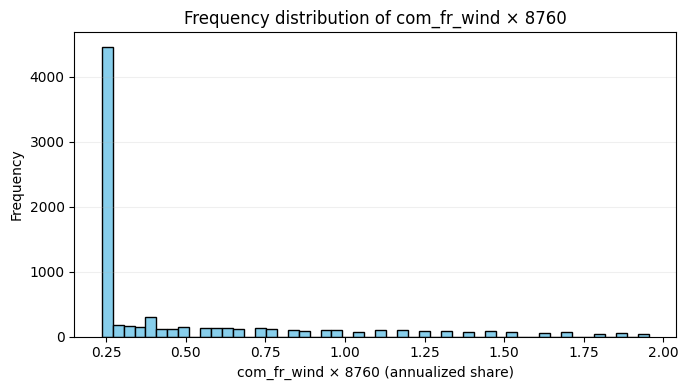

Number of values where com_fr_wind is 0: 0


In [9]:
import xlwings as xw
import pandas as pd

input_iso = 'ITA'

df_sarah_iso = pd.read_csv("data/hourly_profiles/sarah_era5_iso_2013.csv")
df_sarah_iso = df_sarah_iso[df_sarah_iso["iso"] == input_iso]


# display(df_sarah_iso)

import matplotlib.pyplot as plt

# Calculate the scaled wind share
wind_scaled = df_sarah_iso['com_fr_wind'] * 8760
wind_scaled = wind_scaled[wind_scaled < 2]

plt.figure(figsize=(7,4))
plt.hist(wind_scaled, bins=50, color='skyblue', edgecolor='k')
plt.xlabel('com_fr_wind × 8760 (annualized share)')
plt.ylabel('Frequency')
plt.title('Frequency distribution of com_fr_wind × 8760')
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

num_zeros = (df_sarah_iso['com_fr_wind'] == 0).sum()
print(f"Number of values where com_fr_wind is 0: {num_zeros}")

